In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
raw_data1 = pd.read_csv('C:/Users/sjkan/Desktop/방류량 완성.csv', encoding = 'cp949')
raw_data2 = pd.read_csv('C:/Users/sjkan/Desktop/강화대교_조위 완성.csv', encoding = 'cp949')
raw_data3 = pd.read_csv('C:/Users/sjkan/Desktop/청담대교_유량.csv', encoding = 'cp949')
raw_data4 = pd.read_csv('C:/Users/sjkan/Desktop/한강대교_유량 완성.csv', encoding = 'cp949')
raw_data5 = pd.read_csv('C:/Users/sjkan/Desktop/행주대교_유량 수위x4 완성.csv', encoding = 'cp949', usecols = [0])


raw_data = pd.concat([raw_data1,raw_data2,raw_data3,raw_data4,raw_data5], axis = 1)
raw_data
#raw_data = raw_data[:-6912]

,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,575.70,193.0,469.05,729.80,540.18
1,575.30,199.0,498.00,731.48,540.18
2,555.00,207.0,490.68,726.42,540.18
3,575.70,215.0,476.21,726.42,552.17
4,575.40,226.0,476.21,707.17,564.29
...,...,...,...,...,...
276331,258.67,407.0,319.84,-456.41,974.40
276332,258.58,431.0,314.01,-717.30,1006.88
276333,258.56,453.0,387.55,-843.37,1039.90
276334,258.65,476.0,454.91,-1023.37,1073.46


In [11]:
# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
#raw_data.set_index(keys = ['날짜'], inplace = True)
#raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

In [12]:
raw_data.isnull().sum()

방류량           0
강화대교_조위       0
청담대교_유량    1216
한강대교_유량       0
행주대교_유량       0
dtype: int64

In [13]:
raw_data

,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
0,575.70,193.0,469.05,729.80,540.18
1,575.30,199.0,498.00,731.48,540.18
2,555.00,207.0,490.68,726.42,540.18
3,575.70,215.0,476.21,726.42,552.17
4,575.40,226.0,476.21,707.17,564.29
...,...,...,...,...,...
276331,258.67,407.0,319.84,-456.41,974.40
276332,258.58,431.0,314.01,-717.30,1006.88
276333,258.56,453.0,387.55,-843.37,1039.90
276334,258.65,476.0,454.91,-1023.37,1073.46


In [14]:
xdata = raw_data[['방류량','강화대교_조위','한강대교_유량','행주대교_유량']]
xdata

,방류량,강화대교_조위,한강대교_유량,행주대교_유량
0,575.70,193.0,729.80,540.18
1,575.30,199.0,731.48,540.18
2,555.00,207.0,726.42,540.18
3,575.70,215.0,726.42,552.17
4,575.40,226.0,707.17,564.29
...,...,...,...,...
276331,258.67,407.0,-456.41,974.40
276332,258.58,431.0,-717.30,1006.88
276333,258.56,453.0,-843.37,1039.90
276334,258.65,476.0,-1023.37,1073.46


In [22]:
#xdata = xdata[-6912:]
#xdata = xdata.reset_index()
#xdata = xdata[['방류량','강화대교_조위','한강대교_유량','행주대교_유량']]
#xdata

,방류량,강화대교_조위,한강대교_유량,행주대교_유량
0,141.29,478.0,8.23,471.08
1,141.10,461.0,28.82,449.12
2,140.35,446.0,12.35,417.17
3,140.84,430.0,53.52,386.43
4,140.72,415.0,107.04,366.60
...,...,...,...,...
6907,258.67,407.0,-456.41,974.40
6908,258.58,431.0,-717.30,1006.88
6909,258.56,453.0,-843.37,1039.90
6910,258.65,476.0,-1023.37,1073.46


In [15]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = xdata.copy()

for i in range(len(xdata.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

# 원하는 칼럼명 입력하기

In [16]:
#ydata = raw_data[['현재수위','유입량','저수량','공용량','방류량','강화대교_조위','청담대교_유량','잠수교_유량','한강대교_유량']]
ydata = raw_data[['청담대교_유량']]

# 원하는 칼럼명 입력하기

In [17]:
ydata = ydata.reset_index()
ydata = ydata.청담대교_유량
ydata = pd.DataFrame(ydata)
ydata

,청담대교_유량
0,469.05
1,498.00
2,490.68
3,476.21
4,476.21
...,...
276331,319.84
276332,314.01
276333,387.55
276334,454.91


In [18]:
input_regular = pd.concat([input_x_regular, ydata], axis = 1)
input_regular

,방류량,강화대교_조위,한강대교_유량,행주대교_유량,청담대교_유량
0,0.058462,0.191781,0.147596,0.011070,469.05
1,0.058447,0.199253,0.147654,0.011070,498.00
2,0.057689,0.209215,0.147478,0.011070,490.68
3,0.058462,0.219178,0.147478,0.011475,476.21
4,0.058451,0.232877,0.146810,0.011883,476.21
...,...,...,...,...,...
276331,0.046624,0.458281,0.106425,0.025719,319.84
276332,0.046621,0.488169,0.097370,0.026815,314.01
276333,0.046620,0.515567,0.092994,0.027929,387.55
276334,0.046624,0.544209,0.086747,0.029061,454.91


# 원하는 칼럼명 입력하기

In [19]:
input_y_ = input_regular[['청담대교_유량']]
input_x_ = input_regular.drop(input_y_.columns, axis = 1)

In [20]:
input_x_

,방류량,강화대교_조위,한강대교_유량,행주대교_유량
0,0.058462,0.191781,0.147596,0.011070
1,0.058447,0.199253,0.147654,0.011070
2,0.057689,0.209215,0.147478,0.011070
3,0.058462,0.219178,0.147478,0.011475
4,0.058451,0.232877,0.146810,0.011883
...,...,...,...,...
276331,0.046624,0.458281,0.106425,0.025719
276332,0.046621,0.488169,0.097370,0.026815
276333,0.046620,0.515567,0.092994,0.027929
276334,0.046624,0.544209,0.086747,0.029061


In [21]:
input_y_.isnull().sum()

청담대교_유량    1216
dtype: int64

# 원하는 칼럼명 입력하기

In [22]:
nanIndex = input_y_[input_y_['청담대교_유량'].isnull() == True].index

In [23]:
nanIndex

Int64Index([269449, 269450, 269452, 269453, 269454, 269455, 269456, 269457,
            269458, 269459,
            ...
            273770, 273771, 273772, 273773, 273774, 273775, 273776, 273777,
            273778, 273779],
           dtype='int64', length=1216)

In [24]:
from tqdm import tqdm

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-1]
for i in range(len(input_regular.columns)-1):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:25<00:00,  7.80s/it]


In [25]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(276270, 6, 4)
(276270, 1)


In [26]:
# 나중에 학습된 모델에 이거 넣어서 predict해서 결측치 채우기
x_real_predict = []
y_real_predict = []

for i in range(len(nanIndex)):
    k = nanIndex[-(i+1)]
    
    x_real_predict.insert(0,(xdata[k - w * (k // 26496 + 1)]))
    y_real_predict.insert(0,(ydata[k - w * (k // 26496 + 1)]))
    
    xdata.pop(k - w * (k // 26496 + 1))
    ydata.pop(k - w * (k // 26496 + 1))

In [27]:
print(np.array(x_real_predict).shape)
print(np.array(y_real_predict).shape)

(1216, 6, 4)
(1216, 1)


In [28]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [29]:
print(np.array(xdata).shape)
print(np.array(ydata).shape)

(275054, 6, 4)
(275054, 1)


In [30]:
pd.DataFrame(ydata).isnull().sum()

0    0
dtype: int64

In [31]:
xtrain = np.array(xdata[:-50000])
ytrain = np.array(ydata[:-50000])

xtest = np.array(xdata[-50000:])
ytest = np.array(ydata[-50000:])

In [32]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(225054, 6, 4)
(225054, 1)
(50000, 6, 4)
(50000, 1)


## 모델 생성

In [33]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(1))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =["accuracy"])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             576       
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 1, 200)            320800    
                                                        

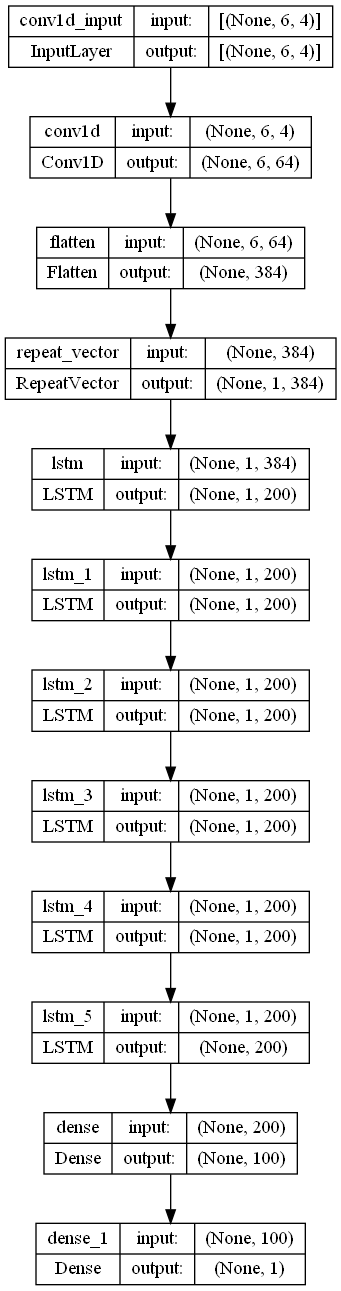

In [34]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [35]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

In [36]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
801/801 [==============================] - 33s 32ms/step - loss: 248.7062 - accuracy: 0.0000e+00 - val_loss: 154.9785 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 2/100
801/801 [==============================] - 25s 31ms/step - loss: 129.2578 - accuracy: 0.0000e+00 - val_loss: 54.4216 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 3/100
801/801 [==============================] - 30s 38ms/step - loss: 106.2797 - accuracy: 0.0000e+00 - val_loss: 102.4896 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 4/100
801/801 [==============================] - 30s 38ms/step - loss: 96.3088 - accuracy: 0.0000e+00 - val_loss: 59.3898 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 5/100
801/801 [==============================] - 30s 38ms/step - loss: 83.8034 - accuracy: 0.0000e+00 - val_loss: 47.0025 - val_accuracy: 0.0000e+00 - lr: 0.0100
Epoch 6/100
801/801 [==============================] - 30s 38ms/step - loss: 81.3657 - accuracy: 0.0000e+00 - val_loss: 62.6320 - val_accuracy: 0.0000e+00 

In [37]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

yhat = keras_model_best.predict(xtest, verbose=1)

yhat

keras_model_best.evaluate(xtest,ytest)

1563/1563 [==============================] - 15s 9ms/step - loss: 78.8700 - accuracy: 0.0000e+00


[78.87002563476562, 0.0]

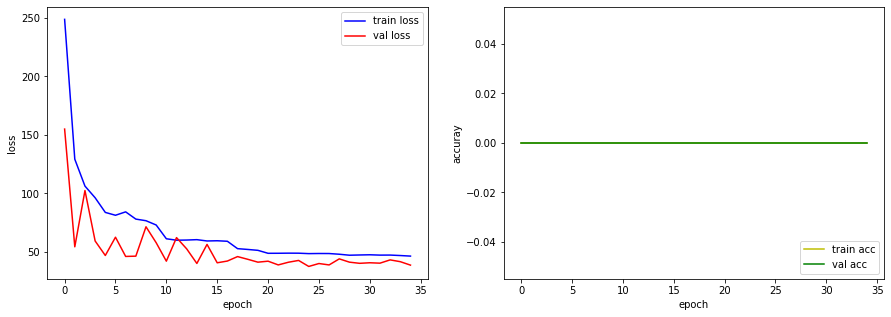

In [38]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

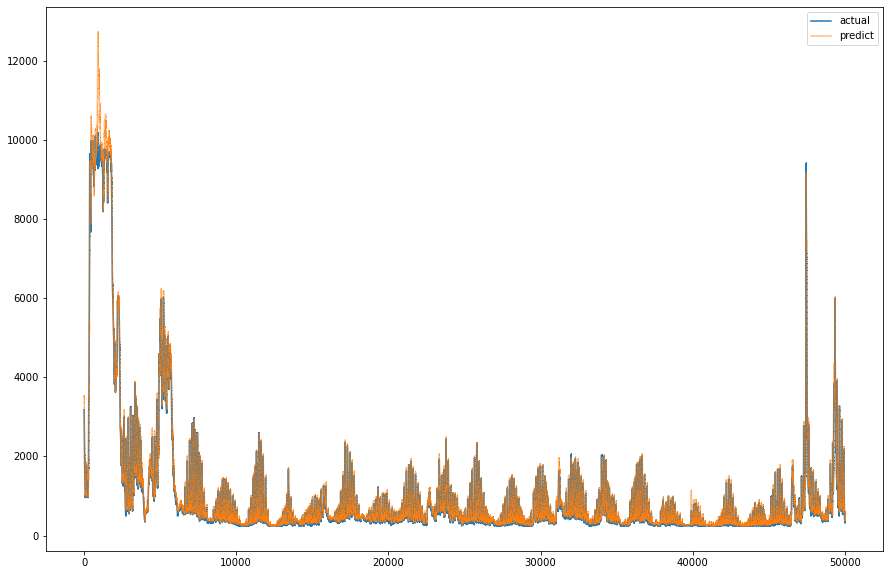

In [39]:
## 결과 시각화

tl_predict = np.array(yhat)

#결과 시각화
plt.figure(figsize=(15,10))
plt.plot(ytest, marker = ",", label = "actual")
plt.plot(tl_predict, marker = ",", label="predict", alpha = 0.5)
plt.legend(prop={'size':10})  

plt.show()

In [40]:
## 점수 확인
print("RMSE : ",float(root_mean_squared_error(ytest, tl_predict)))

RMSE :  151.64999394796396


## 파일 저장
파일명에 '완성' 없으면 마지막 6912개는 raw data

# 원하는 칼럼명 입력하기

In [45]:
raw_data2 = pd.read_csv('C:/Users/sjkan/Desktop/청담대교_유량.csv', encoding = 'cp949')
#raw_data2 = raw_data2[-6912:]
predict_dataset = raw_data2['청담대교_유량']

In [46]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 276336 entries, 0 to 276335
Series name: 청담대교_유량
Non-Null Count   Dtype  
--------------   -----  
275120 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [47]:
predict_dataset.isnull().sum()

1216

In [48]:
predict_dataset.iloc[nanIndex[2]]

nan

In [49]:
y_real_predict

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([na

In [50]:
test_input = np.array(x_real_predict)
y_real_hat = keras_model_best.predict(test_input, verbose=1)

38/38 [==============================] - 0s 8ms/step


In [51]:
y_real_hat

array([[ 274.1962 ],
       [ 271.18546],
       [ 271.90872],
       ...,
       [9401.773  ],
       [9288.654  ],
       [9219.537  ]], dtype=float32)

In [52]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 276336 entries, 0 to 276335
Series name: 청담대교_유량
Non-Null Count   Dtype  
--------------   -----  
275120 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [53]:
predict_dataset.isnull().sum()

1216

In [54]:
for i in range(len(nanIndex)):
    predict_dataset.iloc[nanIndex[i]] = np.float64(y_real_hat[i])

In [55]:
predict_dataset.info()

<class 'pandas.core.series.Series'>
RangeIndex: 276336 entries, 0 to 276335
Series name: 청담대교_유량
Non-Null Count   Dtype  
--------------   -----  
276336 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [56]:
predict_dataset.isnull().sum()

0

In [57]:
predict_dataset

0         469.05
1         498.00
2         490.68
3         476.21
4         476.21
           ...  
276331    319.84
276332    314.01
276333    387.55
276334    454.91
276335    582.21
Name: 청담대교_유량, Length: 276336, dtype: float64

In [ ]:
#addon = raw_data3 = pd.read_csv('C:/Users/sjkan/Desktop/청담대교_유량.csv', encoding = 'cp949')
#addon

In [ ]:
#add = addon[:-6912]
#add

In [58]:
#result = pd.concat([add, pd.DataFrame(predict_dataset)], ignore_index = True)
#result

In [59]:
predict_dataset.to_csv('청담대교_유량 완성.csv', index = False, encoding = 'cp949', columns = ['청담대교_유량'])

# 전체 데이터셋 합치기

In [ ]:
new_data1 = pd.read_csv('C:/Users/sjkan/Desktop/newdata2.csv', encoding = 'cp949', usecols = [0,14,15,16,17])
new_data2 = pd.read_csv('C:/Users/sjkan/Desktop/방류량 완성.csv', encoding = 'cp949')
new_data3 = pd.read_csv('C:/Users/sjkan/Desktop/강화대교_조위 완성.csv', encoding = 'cp949')
new_data4 = pd.read_csv('C:/Users/sjkan/Desktop/청담대교_유량 완성.csv', encoding = 'cp949')
new_data5 = pd.read_csv('C:/Users/sjkan/Desktop/한강대교_유량 완성.csv', encoding = 'cp949')
new_data6 = pd.read_csv('C:/Users/sjkan/Desktop/행주대교_유량 수위x4 완성.csv', encoding = 'cp949')


new_data = pd.concat([new_data1,new_data2,new_data3,new_data4,new_data5,new_data6], axis = 1)
new_data

In [ ]:
new_data.to_csv('newdata4.csv', index = False, encoding = 'cp949')